# Residual Networks with PyTorch

Welcome to the second assignment of this week! You will learn how to build very deep convolutional networks, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously practically feasible.

**In this assignment, you will:**
- Implement the basic building blocks of ResNets. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

In [1]:
# importing packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler, TensorDataset
import torchvision.datasets
import h5py

In [2]:
# helper function to get data
def get_dataset():
    train_dataset = h5py.File('Data - ResNet/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('Data - ResNet/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 1 - The problem of very deep neural networks

Last week, you built your first convolutional neural network. In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 
* However, using a deeper network doesn't always help. **A huge barrier to training them is vanishing gradients**: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow. 
* More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 
* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds: 

<img src="Images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Vanishing gradient** <br> The speed of learning decreases very rapidly for the shallower layers as the network trains </center></caption>

You are now going to solve this problem by building a Residual Network!

## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="Images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : A ResNet block showing a **skip-connection** <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

We also saw in lecture that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
(There is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more so than skip connections helping with vanishing gradients).

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

### 2.1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="Images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually **implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers.** It looks like this: 

<img src="Images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. Please read over this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [See reference](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)
- To implement BatchNorm: [See reference](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)
- For the activation, use: `nn.ReLU()`

In [28]:
# GRADED FUNCTION (in pytorch --> classs): identity_block
class identity_block(nn.Module):
    def __init__(self, filters, inp_channels):
        super(identity_block, self).__init__()
        # get dims of filters
        F1, F2 = filters
        
        # first component
        self.CONV2D_1 = nn.Conv2d(inp_channels, F1, kernel_size=1)
        self.BatchNorm_1 = nn.BatchNorm2d(F1)
        self.ReLU_1 = nn.ReLU()
        
        # second component
        self.CONV2D_2 = nn.Conv2d(F1, F2, kernel_size=3, padding=1) # same (dims) convolution
        self.BatchNorm_2 = nn.BatchNorm2d(F2)
        self.ReLU_2 = nn.ReLU()
        
        # third component when the output dims must match the inp_channel dims (shortcut remember)
        self.CONV2D_3 = nn.Conv2d(F2, inp_channels, kernel_size=1)
        self.BatchNorm_3 = nn.BatchNorm2d(inp_channels)
        self.ReLU_3 = nn.ReLU()
        
    def forward(self, x):
        # save input for shortcut path
        x_shortcut = x
        
        # first comp forward
        x = self.CONV2D_1(x)
        x = self.BatchNorm_1(x)
        x = self.ReLU_1(x)
        
        # second comp forward
        x = self.CONV2D_2(x)
        x = self.BatchNorm_2(x)
        x = self.ReLU_2(x)
        
        # third comp where we add to x intial activation before doing relu
        x = self.CONV2D_3(x)
        x = self.BatchNorm_3(x)
        # here
        x += x_shortcut
        x = self.ReLU_3(x)
    
        return x

## 2.2 - The convolutional block

You've implemented the ResNet identity block. Next, the ResNet "convolutional block" is the other type of block. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="Images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Convolutional block** </center></caption>

**The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.** (This plays a similar role as the matrix $W_s$ discussed in lecture.) For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". 
- The first BatchNorm is normalizing the channels axis. 
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same".
- The second BatchNorm is normalizing the channels axis.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid".
- The third BatchNorm is normalizing the channels axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".
- The BatchNorm is normalizing the channels axis.

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    
**Exercise**: Implement the convolutional block. We have implemented the first component of the main path; you should implement the rest. As before, always use 0 as the seed for the random initialization, to ensure consistency with our grader.
- [Conv Hint](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)
- [BatchNorm Hint](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)
- For the activation, use: `nn.ReLU()`

In [40]:
# GRADED FUNCTION (in pytorch --> classs): convolutional_block
class conv_block(nn.Module):
    def __init__(self, filters, Stride, inp_channels):
        super(conv_block, self).__init__()
        # get dims of filters
        F1, F2, F3 = filters
        
        # first comp
        self.CONV2D_1 = nn.Conv2d(inp_channels, F1, kernel_size=1, stride=Stride)
        self.BatchNorm_1 = nn.BatchNorm2d(F1)
        self.ReLU_1 = nn.ReLU()
        
        # second comp
        self.CONV2D_2 = nn.Conv2d(F1, F2, kernel_size=3, padding=1) # same conv to preserve dims (3x3 here)
        self.BatchNorm_2 = nn.BatchNorm2d(F2)
        self.ReLU_2 = nn.ReLU()
        
        # third comp
        self.CONV2D_3 = nn.Conv2d(F2, F3, kernel_size=1)
        self.BatchNorm_3 = nn.BatchNorm2d(F3)
        
        # shortcut comp
        # After this, input sizes and the number of channels will match.
        self.CONV2D_shortcut = nn.Conv2d(inp_channels, F3, kernel_size=1, stride=Stride)
        self.BatchNorm_shortcut = nn.BatchNorm2d(F3)
        
        # final relu
        self.ReLU_3 = nn.ReLU()
    
    def forward(self, x):
        # save input for shortcut path
        x_shortcut = x
            
        # first comp
        x = self.CONV2D_1(x)
        x = self.BatchNorm_1(x)
        x = self.ReLU_1(x)
        
        # second comp
        x = self.CONV2D_2(x)
        x = self.BatchNorm_2(x)
        x = self.ReLU_2(x)
        
        # third comp
        x = self.CONV2D_3(x)
        x = self.BatchNorm_3(x)
        
        x_shortcut = self.CONV2D_shortcut(x_shortcut)
        x_shortcut = self.BatchNorm_shortcut(x_shortcut)
        
        # add shortcut residual layer activation before final layer
        x += x_shortcut
        x = self.ReLU_3(x)
        
        return x


## 3 - Building your first ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="Images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1.
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3.
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2.
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3.
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2.
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3.
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2.
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The flatten doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

**Exercise**: Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2.) Make sure you follow the naming convention in the text above. 

In [41]:
# utility class for flattening before FC layer
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ResNet50 = nn.Sequential(
    # zero padding of 3x3
    nn.ConstantPad2d(3, 0),
    # -- Stage 1 --
    nn.Conv2d(3, 64, kernel_size=7, stride=2),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # -- Stage 2 --
    conv_block((64, 64, 256), Stride=1, inp_channels=64),
    identity_block((64, 64), inp_channels=256),
    identity_block((64, 64), inp_channels=256),
    # -- Stage 3 --
    conv_block((128, 128, 512), Stride=2, inp_channels=256),
    identity_block((128, 128), inp_channels=512),
    identity_block((128, 128), inp_channels=512),
    identity_block((128, 128), inp_channels=512),
    # -- Stage 4 -- 
    conv_block((256, 256, 1024), Stride=2, inp_channels=512),
    identity_block((256, 256), inp_channels=1024),
    identity_block((256, 256), inp_channels=1024),
    identity_block((256, 256), inp_channels=1024),
    identity_block((256, 256), inp_channels=1024),
    identity_block((256, 256), inp_channels=1024),
    # -- Stage 5 --
    conv_block((512, 512, 2048), Stride=2,inp_channels=1024),
    identity_block((512, 512), inp_channels=2048),
    identity_block((512, 512), inp_channels=2048),
    # -- Average Pooling
    nn.AvgPool2d(kernel_size=2), # after this dims --> 1x1x2048
    # -- FC Dense Layer --
    Flatten(),
    nn.Linear(2048, 6)
).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(ResNet50.parameters(), lr=0.0001)

### Load Train / Test Datasets

In [43]:
X_train, Y_train, X_test, Y_test, classes = get_dataset()
#swap axes to make them usable by PyTorch
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()
X_train = X_train/255
X_test = X_test/255
print ("NO. of training examples = " + str(X_train.shape[0]))
print ("NO. of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

NO. of training examples = 1080
NO. of test examples = 120
X_train shape: (1080, 3, 64, 64)
Y_train shape: (1080,)
X_test shape: (120, 3, 64, 64)
Y_test shape: (120,)


In [44]:
n_train, n_test = 1080, 120
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [45]:
def get_accuracy(model, loader_test):
    model.eval()
    num_samples, num_correct = 0, 0
    with torch.no_grad():
        for x, y in loader_test:
            x, y = x.to(device), y.to(device)
            output = model(x)
            _, y_pred = output.data.max(1)
            num_correct += (y_pred == y).sum().item()
            num_samples += x.size(0)
            
    return num_correct/num_samples
    
def train(model, loss_fn, optimizer, loader_train, loader_test, epochs=1):
    for epoch in range(epochs):
        model.train()
        for i, (x, y) in enumerate(loader_train):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y)
            loss.backward()
            
            optimizer.step()
        acc = get_accuracy(model, loader_test)
        print(f"Epoch: {epoch+1} | Loss: {loss.item()} | Test accuracy: {acc}")

In [46]:
train(ResNet50, loss_fn, opt, train_dl, test_dl, epochs=3)

Epoch: 1 | Loss: 1.3503938913345337 | Test accuracy: 0.16666666666666666
Epoch: 2 | Loss: 1.0487544536590576 | Test accuracy: 0.5083333333333333
Epoch: 3 | Loss: 0.5729032158851624 | Test accuracy: 0.6333333333333333


In [48]:
train(ResNet50, loss_fn, opt1, train_dl, test_dl, epochs=15)

Epoch: 1 | Loss: 1.6263527870178223 | Test accuracy: 0.2833333333333333
Epoch: 2 | Loss: 1.1282259225845337 | Test accuracy: 0.5416666666666666
Epoch: 3 | Loss: 1.0681161880493164 | Test accuracy: 0.7333333333333333
Epoch: 4 | Loss: 0.8514626026153564 | Test accuracy: 0.7666666666666667
Epoch: 5 | Loss: 0.7295946478843689 | Test accuracy: 0.6916666666666667
Epoch: 6 | Loss: 0.5615009665489197 | Test accuracy: 0.8083333333333333
Epoch: 7 | Loss: 0.9938809871673584 | Test accuracy: 0.7416666666666667
Epoch: 8 | Loss: 0.5174221396446228 | Test accuracy: 0.8166666666666667
Epoch: 9 | Loss: 0.49971213936805725 | Test accuracy: 0.85
Epoch: 10 | Loss: 0.7834341526031494 | Test accuracy: 0.825
Epoch: 11 | Loss: 0.2872827649116516 | Test accuracy: 0.8
Epoch: 12 | Loss: 0.3218795955181122 | Test accuracy: 0.85
Epoch: 13 | Loss: 0.6755287051200867 | Test accuracy: 0.825
Epoch: 14 | Loss: 0.27384182810783386 | Test accuracy: 0.8916666666666667
Epoch: 15 | Loss: 0.3739222288131714 | Test accuracy: 

In [49]:
# ResNet34 from PyTorch Model Hub
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/pseudocodenerd/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/pseudocodenerd/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100.0%


In [51]:
opt2 = optim.Adam(model.parameters(), lr=0.0001)
train(model, loss_fn, opt2, train_dl, test_dl, epochs=5)

Epoch: 1 | Loss: 0.5657508969306946 | Test accuracy: 0.7
Epoch: 2 | Loss: 0.48399385809898376 | Test accuracy: 0.9666666666666667
Epoch: 3 | Loss: 0.05535838007926941 | Test accuracy: 0.9833333333333333
Epoch: 4 | Loss: 0.019895106554031372 | Test accuracy: 0.9666666666666667
Epoch: 5 | Loss: 0.04867398366332054 | Test accuracy: 0.975


As expected, the pretrained resnet from the model zoo performs exceptionally. My implementation is pretty decent too on the test set.

In [60]:
torch.save(ResNet50.state_dict(), 'my-ResNet50.pth')

### Testing both models on real life data (images of my hands)

In [73]:
import matplotlib.pyplot as plt
import cv2

def img2tensor(image_path, input_size, device):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (input_size, input_size))                  #Resize
    img = img[..., ::-1].transpose((2, 0, 1))                        #BGR -> RGB and HxWxC -> CxHxW
    img = img[np.newaxis, ...] / 255.0                               #Add a channel at 0, thus making it a batch
    img = torch.tensor(img, dtype=torch.float, device=device)        #Convert to Tensor
    return img

tensor(0)


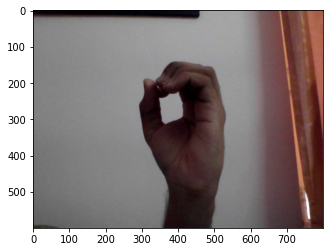

In [76]:
# ResNet50 : Mine
img_path = "Images/0.jpg"
plt.imshow(plt.imread(img_path))
inp = img2tensor(img_path, 64, device) # image tensor after normalizing and resizing
y_pred = ResNet50(inp)
_, y_pred_cls = y_pred.data.max(1)
print(y_pred_cls[0])

tensor(3)


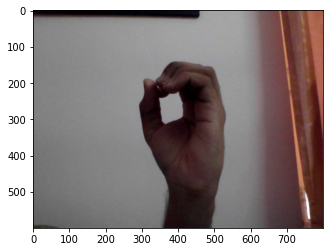

In [77]:
# ResNet50 : PyTorch's
img_path = "Images/0.jpg"
plt.imshow(plt.imread(img_path))
inp = img2tensor(img_path, 64, device) # image tensor after normalizing and resizing
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print(y_pred_cls[0])

As we can say, my model accurately predicts this image to be of 0 but in an unfortunate turn of events, the pytorch's rep ResNet pretrained classifies this as a 3. Oof

tensor(4)


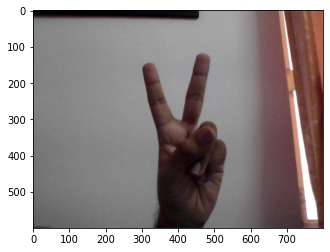

In [78]:
# ResNet50 : Mine
img_path = "Images/2.jpg"
plt.imshow(plt.imread(img_path))
inp = img2tensor(img_path, 64, device) # image tensor after normalizing and resizing
y_pred = ResNet50(inp)
_, y_pred_cls = y_pred.data.max(1)
print(y_pred_cls[0])

tensor(2)


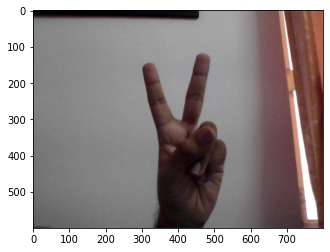

In [79]:
# ResNet50 : Mine
img_path = "Images/2.jpg"
plt.imshow(plt.imread(img_path))
inp = img2tensor(img_path, 64, device) # image tensor after normalizing and resizing
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print(y_pred_cls[0])

Ahh it's a tie ! My ResNet says that this is 4 but actually like the OP resnet says, this is infact a two.

### FIN.